# libs

In [ ]:
import os
from os import listdir
from os.path import isfile, join

from skimage import transform,io
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import random

import pickle 

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras import layers

# Classes

In [ ]:
classes = ['Fighting', 'Bug', 'Ghost', 'Electric', 'Grass', 'Rock', 'Water', 'Dragon', 'Ice', 'Fire', 'Ground', 'Dark', 'Fairy', 'Normal', 'Flying', 'Steel', 'Poison', 'Psychic']

# Preparing Data

In [ ]:
train_imgs_path = []
for i,cl in enumerate(classes):
    for f in listdir("/content/drive/MyDrive/pokemon_dataset/stano/train/{}".format(cl)):
            train_imgs_path.append((join("/content/drive/MyDrive/pokemon_dataset/stano/train/",cl, f),i))
random.shuffle(train_imgs_path)

In [ ]:
test_path = "/content/drive/MyDrive/pokemon_dataset/stano/test"
test_imgs_path = [join(test_path, f) for f in listdir(test_path)]

# Working with data

In [ ]:
def getImage(path, input_image_size):
    # Read and normalize an image
    train_img = io.imread(path)/255.0
    train_img = transform.resize(train_img,(input_image_size[0],input_image_size[1]))
    # Resize
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img


def dataGenerator(images, input_image_size=(224,224), batch_size=4,class_num=18):
    
    dataset_size = len(images)
    c = 0
    while(True):
        x_train = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        y_train = np.zeros((batch_size, class_num)).astype('float')
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            img_path = images[i][0]
            img_label = images[i][1]

            train_img = getImage(img_path, input_image_size)
            label = to_categorical(img_label,num_classes=class_num)              
            
            x_train[i-c] = train_img
            y_train[i-c] = label
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
        yield x_train, y_train

# Creating Model

In [ ]:
def CreateModel(act_fun,num_classes,input_shape):
    model = Sequential()
    model.add(Conv2D(6, (5, 5), activation=act_fun,padding="same", input_shape=input_shape))
    model.add(MaxPooling2D((2, 2),strides=(2,2)))
    model.add(Conv2D(16, (5, 5), activation=act_fun,padding="valid",))
    model.add(MaxPooling2D((2, 2),strides=(2,2)))
    model.add(Conv2D(120, (5, 5), activation=act_fun,padding="valid",))
    model.add(Flatten())
    model.add(Dense(84,activation = act_fun))
    model.add(Dense(num_classes,activation = "softmax"))
    return model

In [ ]:
input_image_size = (128,128)

model = CreateModel("relu",18,input_image_size + (3,))

In [ ]:

!gdown https://drive.google.com/uc?id={"1MHmkXm5iUujt4DefpD5lO9ybyUlFqPDT"}
model.load_weights("./weights_3.hdf5")

In [ ]:
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy', # Loss
    metrics=["accuracy"]
    )

# Training

In [ ]:

dataset_size = len(train_imgs_path)
batch_size = 512

train_generator = dataGenerator(train_imgs_path, input_image_size=input_image_size,batch_size=batch_size)

In [ ]:
n_epochs = 5
steps_per_epoch = dataset_size // batch_size


# Start the training process

history = model.fit(x = train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = n_epochs,
                    verbose = 1)


Epoch 1/5
59/59 [==============================] - 815s 14s/step - loss: 0.5406 - accuracy: 0.8303
Epoch 2/5
59/59 [==============================] - 817s 14s/step - loss: 0.3443 - accuracy: 0.9002
Epoch 3/5
59/59 [==============================] - 810s 14s/step - loss: 0.3030 - accuracy: 0.9102
Epoch 4/5
59/59 [==============================] - 806s 14s/step - loss: 0.2823 - accuracy: 0.9147
Epoch 5/5
59/59 [==============================] - 806s 14s/step - loss: 0.2332 - accuracy: 0.9319


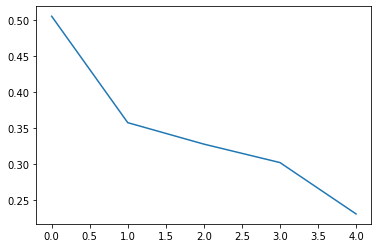

In [ ]:
plt.plot(history.history["loss"])

# Testgin model

Fire


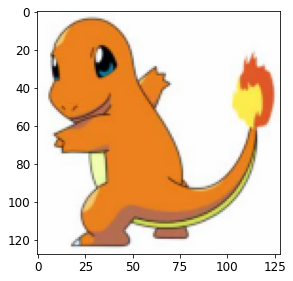

In [ ]:
import requests
from skimage import io,transform
IMAGE_URL = 'https://pmg.gishan.cc/static/i/p/charmander.jpg'  #@param {type:"string"}

url = IMAGE_URL

try:
    img_data = requests.get(url)
    if img_data.status_code == 200:
        imgContent = img_data.content
        with open('testimg.jpg', 'wb') as handler:
            handler.write(imgContent)
        test_img = io.imread("./testimg.jpg")
        test_img = transform.resize(test_img,input_image_size)
        test_img = np.reshape(test_img,(1,input_image_size[0],input_image_size[1],3))
    else:
        print('Cannot retrieve image. Please check url: ' + url)
    plt.rcParams.update({'font.size': 12})
    predictions = model.predict(test_img)
    prediction = predictions[0]
    prediction = np.argmax(prediction)
    print(classes[prediction])
    plt.figure(figsize=(20,10))
    plt.subplot(141)
    plt.imshow(test_img[0])
except IOError:
    print('Cannot retrieve image. Please check url: ' + url)

